# LSTM Forecasting

In [1]:
# --- Repo path bootstrap so imports like `from price_forecast...` work ---
import os, sys
REPO_ROOT = os.path.abspath(os.path.join(os.path.dirname("__file__"), ".."))
SRC_ROOT = os.path.join(REPO_ROOT, "src")
if SRC_ROOT not in sys.path:
    sys.path.insert(0, SRC_ROOT)

# Optional, for iterative dev:

data_dir = os.path.join(REPO_ROOT, "data")  # where data is stored

In [2]:
SRC_ROOT

'c:\\Users\\HarrisDeralas\\Downloads\\panagiotis_files\\price_forecast\\src'

In [3]:
data_dir

'c:\\Users\\HarrisDeralas\\Downloads\\panagiotis_files\\price_forecast\\data'

## Build the dataset

In [4]:
import pandas as pd
import numpy as np

from price_forecast.config import (
    TimezoneConfig, Naming, DAMConfig, WeatherConfig, WeatherSite
)
from price_forecast.pipeline.dataset_builder import DatasetBuilder
from price_forecast.utils.merge import TimeSeriesMerger


In [5]:
from entsoe import EntsoePandasClient
client = EntsoePandasClient(api_key="7260b39e-b41a-4905-a402-4a65bd531f3f")

In [6]:
tz_cfg = TimezoneConfig()
naming = Naming(dt_local="datetime_local", dam_price="dam_price_eur_mwh")
dam_cfg = DAMConfig(base_dir="../data")
sites = [
    WeatherSite("athens", 37.98, 23.72),
    WeatherSite("thessaloniki", 40.64, 22.94),
    WeatherSite("heraklion", 35.34, 25.13),
]
wx_cfg = WeatherConfig()

In [7]:
builder = DatasetBuilder(
    tz_cfg=tz_cfg,
    naming=naming,
    dam_cfg=dam_cfg,
    weather_sites=sites,
    weather_cfg=wx_cfg,
    entsoe_client=client,
    entsoe_prefix="entsoe_",
)

In [8]:
df  = builder.create_dataset(start_date="2020-11-01", end_date="2023-12-31", add_prev_day=True, add_diff=True, as_relative=False)

Finished building DAM data.
Finished building ENTSO-E data.
Finished building Weather data.
Finished merging all data on UTC axis.
Converted merged data back to local timezone.
Added previous-day DAM price feature.
Added difference features for DAM price and previous-day DAM price.


<Axes: xlabel='dam_price_eur_mwh', ylabel='Count'>

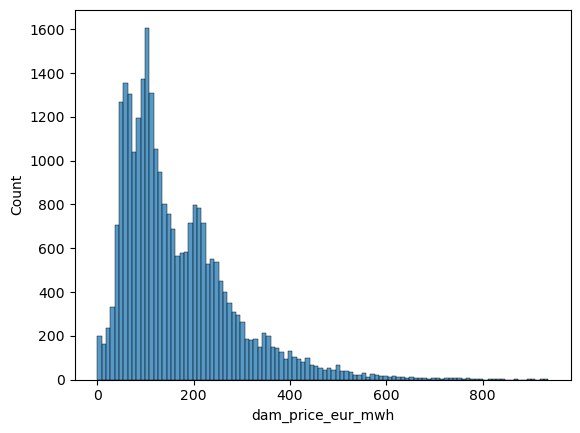

In [9]:
import seaborn as sns
sns.histplot(df['dam_price_eur_mwh'])

## Visualize the DAM series

In [10]:
import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=df["datetime_local"],
        y=df["dam_price_eur_mwh"],
        name="DAM Price",
        mode="lines"
    )
)

fig.add_trace(
    go.Scatter(
        x=df["datetime_local"],
        y=df["previous_day_dam"],
        name="Previous Day DAM Price",
        mode="lines"
    )
)

fig.update_layout(
    title="Day-Ahead Market Prices",
    xaxis_title="Date",
    yaxis_title="Price (EUR/MWh)",
    hovermode="x unified",
    xaxis=dict(rangeslider=dict(visible=True), type="date"),
    legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1)
)

fig.show()


## Generate dataset for LSTM ingestion

In [9]:
from price_forecast.config import DatasetCfg

cfgd = DatasetCfg(n_lookback_days=30,test_size=0.2,put_main_first = True)

In [23]:
from price_forecast.datasets.daily_sequence import DailySequenceDataset

builder = DailySequenceDataset(df, cfgd)
data = builder.build(return_dfs=True,keep_only_diff=False,diff_as_target=True)

# scaled for training
X_train, y_train = data["X_train"], data["y_train"]

X_test, y_test = data["X_test"], data["y_test"]

# unscaled for metrics/plots/inverse checks
X_train_raw, y_train_raw = data["X_train_raw"], data["y_train_raw"]

X_test_raw, y_test_raw = data["X_test_raw"], data["y_test_raw"]

y_train_bases, y_test_bases = data["y_train_bases"], data["y_test_bases"]
# tidy inspection (raw vs scaled)
X_train_df_raw = data["X_train_df_raw"]
X_train_df_scaled = data["X_train_df"]
y_train_df_raw = data["y_train_df_raw"]
X_test_df_raw = data["X_test_df_raw"]
y_test_df_raw = data["y_test_df_raw"]

c:\Users\HarrisDeralas\Downloads\panagiotis_files\price_forecast\src\price_forecast\datasets\daily_sequence.py:325: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  if not np.all(diffs.view("i8") == pd.Timedelta(hours=1).value):


Initial feature columns: ['previous_day_dam', 'entsoe_Solar', 'entsoe_Wind Onshore', 'temperature_2m_athens', 'cloudcover_athens', 'wind_speed_100m_athens', 'shortwave_radiation_athens', 'temperature_2m_thessaloniki', 'cloudcover_thessaloniki', 'wind_speed_100m_thessaloniki', 'shortwave_radiation_thessaloniki', 'temperature_2m_heraklion', 'cloudcover_heraklion', 'wind_speed_100m_heraklion', 'shortwave_radiation_heraklion', 'wx_temp_avg_c', 'wx_cloud_avg_pct', 'wx_wind100_avg', 'wx_swr_avg', 'wx_wind_power_idx', 'wx_solar_power_idx', 'dam_price_eur_mwh_diff', 'previous_day_dam_diff', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos', 'month_sin', 'month_cos', 'is_weekend']
@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@@
Removed absolute target 'dam_price_eur_mwh_diff' from features to avoid leakage.


In [14]:
c = data['meta']['feature_cols']
c

['previous_day_dam',
 'entsoe_Solar',
 'entsoe_Wind Onshore',
 'temperature_2m_athens',
 'cloudcover_athens',
 'wind_speed_100m_athens',
 'shortwave_radiation_athens',
 'temperature_2m_thessaloniki',
 'cloudcover_thessaloniki',
 'wind_speed_100m_thessaloniki',
 'shortwave_radiation_thessaloniki',
 'temperature_2m_heraklion',
 'cloudcover_heraklion',
 'wind_speed_100m_heraklion',
 'shortwave_radiation_heraklion',
 'wx_temp_avg_c',
 'wx_cloud_avg_pct',
 'wx_wind100_avg',
 'wx_swr_avg',
 'wx_wind_power_idx',
 'wx_solar_power_idx',
 'previous_day_dam_diff',
 'hour_sin',
 'hour_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'is_weekend']

In [15]:
builder.feature_cols_all

['previous_day_dam',
 'entsoe_Solar',
 'entsoe_Wind Onshore',
 'temperature_2m_athens',
 'cloudcover_athens',
 'wind_speed_100m_athens',
 'shortwave_radiation_athens',
 'temperature_2m_thessaloniki',
 'cloudcover_thessaloniki',
 'wind_speed_100m_thessaloniki',
 'shortwave_radiation_thessaloniki',
 'temperature_2m_heraklion',
 'cloudcover_heraklion',
 'wind_speed_100m_heraklion',
 'shortwave_radiation_heraklion',
 'wx_temp_avg_c',
 'wx_cloud_avg_pct',
 'wx_wind100_avg',
 'wx_swr_avg',
 'wx_wind_power_idx',
 'wx_solar_power_idx',
 'dam_price_eur_mwh_diff',
 'previous_day_dam_diff',
 'hour_sin',
 'hour_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'is_weekend']

In [16]:
builder._target_diff_col

'dam_price_eur_mwh_diff'

In [17]:
builder.feature_cols_all

['previous_day_dam',
 'entsoe_Solar',
 'entsoe_Wind Onshore',
 'temperature_2m_athens',
 'cloudcover_athens',
 'wind_speed_100m_athens',
 'shortwave_radiation_athens',
 'temperature_2m_thessaloniki',
 'cloudcover_thessaloniki',
 'wind_speed_100m_thessaloniki',
 'shortwave_radiation_thessaloniki',
 'temperature_2m_heraklion',
 'cloudcover_heraklion',
 'wind_speed_100m_heraklion',
 'shortwave_radiation_heraklion',
 'wx_temp_avg_c',
 'wx_cloud_avg_pct',
 'wx_wind100_avg',
 'wx_swr_avg',
 'wx_wind_power_idx',
 'wx_solar_power_idx',
 'dam_price_eur_mwh_diff',
 'previous_day_dam_diff',
 'hour_sin',
 'hour_cos',
 'day_sin',
 'day_cos',
 'month_sin',
 'month_cos',
 'is_weekend']

In [18]:
len(X_train_df_raw.columns)

30

In [19]:
X_train.shape

(901, 720, 29)

In [20]:
df.loc[(df['datetime_local'] >= y_train_df_raw['datetime'].min()) & (df['datetime_local'] <= y_train_df_raw['datetime'].max())][['datetime_local','dam_price_eur_mwh_diff','dam_price_eur_mwh']].tail(60)


,datetime_local,dam_price_eur_mwh_diff,dam_price_eur_mwh
22284,2023-05-18 13:00:00+03:00,0.000000,93.850000
22285,2023-05-18 14:00:00+03:00,1.750000,95.600000
22286,2023-05-18 15:00:00+03:00,6.370000,101.970000
22287,2023-05-18 16:00:00+03:00,6.380000,108.350000
22288,2023-05-18 17:00:00+03:00,3.650000,112.000000
22289,2023-05-18 18:00:00+03:00,10.190000,122.190000
22290,2023-05-18 19:00:00+03:00,20.760000,142.950000
22291,2023-05-18 20:00:00+03:00,30.538824,173.488824
22292,2023-05-18 21:00:00+03:00,-48.038824,125.450000
22293,2023-05-18 22:00:00+03:00,-11.290000,114.160000


In [21]:
y_train_df_raw.tail(60)

datetime  dam_price_eur_mwh_diff
sample hour                                                  
898    12   2023-05-18 13:00:00+03:00                0.000000
       13   2023-05-18 14:00:00+03:00                1.750000
       14   2023-05-18 15:00:00+03:00                6.370000
       15   2023-05-18 16:00:00+03:00                6.380000
       16   2023-05-18 17:00:00+03:00                3.650000
       17   2023-05-18 18:00:00+03:00               10.190000
       18   2023-05-18 19:00:00+03:00               20.760000
       19   2023-05-18 20:00:00+03:00               30.538824
       20   2023-05-18 21:00:00+03:00              -48.038824
       21   2023-05-18 22:00:00+03:00              -11.290000
       22   2023-05-18 23:00:00+03:00               -3.660000
       23   2023-05-19 00:00:00+03:00                2.230000
899    0    2023-05-19 01:00:00+03:00              -13.650000
       1    2023-05-19 02:00:00+03:00               -2.980000
       2    2023-05-19 03:00:00+03:00                0.000000
       3    2023-05-19 04:00:00+03:00               -0.400000
       4    2023-05-19 05:00:00+03:00                7.640000
       5    2023-05-19 06:00:00+03:00                9.520000
       6    2023-05-19 07:00:00+03:00               12.140000
       7    2023-05-19 08:00:00+03:00                9.519375
       8    2023-05-19 09:00:00+03:00               -8.909375
       9    2023-05-19 10:00:00+03:00               -7.130000
       10   2023-05-19 11:00:00+03:00               -1.440000
       11   2023-05-19 12:00:00+03:00               -9.530000
       12   2023-05-19 13:00:00+03:00              -19.500625
       13   2023-05-19 14:00:00+03:00                1.990625
       14   2023-05-19 15:00:00+03:00               21.170000
       15   2023-05-19 16:00:00+03:00                3.690000
       16   2023-05-19 17:00:00+03:00               -2.960000
       17   2023-05-19 18:00:00+03:00                8.810000
       18   2023-05-19 19:00:00+03:00               19.950000
       19   2023-05-19 20:00:00+03:00                4.340000
       20   2023-05-19 21:00:00+03:00              -17.690000
       21   2023-05-19 22:00:00+03:00              -16.870000
       22   2023-05-19 23:00:00+03:00                0.730000
       23   2023-05-20 00:00:00+03:00               -4.210000
900    0    2023-05-20 01:00:00+03:00               -3.120000
       1    2023-05-20 02:00:00+03:00               -1.860000
       2    2023-05-20 03:00:00+03:00               -6.270000
       3    2023-05-20 04:00:00+03:00               -4.010000
       4    2023-05-20 05:00:00+03:00                1.800000
       5    2023-05-20 06:00:00+03:00               10.500000
       6    2023-05-20 07:00:00+03:00               -1.290000
       7    2023-05-20 08:00:00+03:00              -42.950000
       8    2023-05-20 09:00:00+03:00              -19.720000
       9    2023-05-20 10:00:00+03:00              -35.250000
       10   2023-05-20 11:00:00+03:00               -3.840000
       11   2023-05-20 12:00:00+03:00               -0.100000
       12   2023-05-20 13:00:00+03:00               -0.850000
       13   2023-05-20 14:00:00+03:00                0.000000
       14   2023-05-20 15:00:00+03:00                0.000000
       15   2023-05-20 16:00:00+03:00               59.990000
       16   2023-05-20 17:00:00+03:00               34.770000
       17   2023-05-20 18:00:00+03:00               14.550000
       18   2023-05-20 19:00:00+03:00                6.710000
       19   2023-05-20 20:00:00+03:00                3.980000
       20   2023-05-20 21:00:00+03:00              -11.870000
       21   2023-05-20 22:00:00+03:00               -1.310000
       22   2023-05-20 23:00:00+03:00               -3.860000
       23   2023-05-21 00:00:00+03:00               -6.270000

In [ ]:
# cfgd = DatasetCfg(
#     datetime_col="datetime_local",
#     target_col="dam_price_eur_mwh",
#     n_lookback_days=60,
#     test_size=0.2,
#     main_series="previous_day_dam",
#     put_main_first=True,
# )

# builder = DailySequenceDataset(df, cfgd)
# data = builder.build(return_dfs=True)

# # scaled for training
# X_train, y_train = data["X_train"], data["y_train"]

# # unscaled for metrics/plots/inverse checks
# X_train_raw, y_train_raw = data["X_train_raw"], data["y_train_raw"]

# # tidy inspection (raw vs scaled)
# X_train_df_raw = data["X_train_df_raw"]
# X_train_df_scaled = data["X_train_df"]
# y_train_df_raw = data["y_train_df_raw"]
# X_test_df_raw = data["X_test_df_raw"]
# y_test_df_raw = data["y_test_df_raw"]


# # scaled arrays for training
# X_train, X_test = data["X_train"], data["X_test"]
# y_train, y_test = data["y_train"], data["y_test"]



c:\Users\HarrisDeralas\Downloads\panagiotis_files\price_forecast\src\price_forecast\datasets\daily_sequence.py:139: FutureWarning:

Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.



## Train the LSTM(s)

In [46]:
# X_train: (batch, input_steps, n_features)
# y_train: (batch, output_steps, output_dim)
from price_forecast.models.lstm_seq2seq import LSTMSeq2SeqModel
model = LSTMSeq2SeqModel.from_training_data(
    X_train, y_train,
    lstm_units=15*8,
    dropout=0.2,
)

# Optional explicit tail validation split
split = int(0.9 * X_train.shape[0])
history = model.fit(
    X_train=X_train[:split], y_train=y_train[:split],
    X_val=X_train[split:],   y_val=y_train[split:],
    epochs=200, batch_size=64, patience=10, reduce_lr_patience=5,
    checkpoint_path="best_lstm.keras",
    verbose=1,
)

# Predict, invert scaling with your builder, evaluate, and persist
y_pred_scaled = model.predict(X_test)
y_pred = builder.inverse_transform_target(y_pred_scaled, bases=y_test_bases,diff_as_target=True)
y_true = builder.inverse_transform_target(y_test, bases=y_test_bases,diff_as_target=True)
print(LSTMSeq2SeqModel.evaluate(y_true, y_pred))
print(LSTMSeq2SeqModel.evaluate(y_true, y_pred))





c:\Users\HarrisDeralas\anaconda3\envs\price-forecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "lstm_seq2seq_day_ahead"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_lstm (LSTM)             │ (None, 120)            │        72,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout (Dropout)       │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_output_steps             │ (None, 24, 120)        │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 24, 120)        │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout (Dropout)       │ (None, 24, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hourly_output (TimeDistributed) │ (None, 24, 1)          │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,801 (733.60 KB)

 Trainable params: 187,801 (733.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 815ms/step - loss: 0.4581 - mae: 0.3907
Epoch 1: val_loss improved from None to 0.50164, saving model to best_lstm.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 14s 883ms/step - loss: 1.0835 - mae: 0.6127 - val_loss: 0.5016 - val_mae: 0.4582 - learning_rate: 0.0010
Epoch 2/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 831ms/step - loss: 0.4451 - mae: 0.3707
Epoch 2: val_loss did not improve from 0.50164
13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 870ms/step - loss: 1.0797 - mae: 0.6001 - val_loss: 0.5081 - val_mae: 0.4715 - learning_rate: 0.0010
Epoch 3/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 910ms/step - loss: 0.4593 - mae: 0.4020
Epoch 3: val_loss did not improve from 0.50164
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 944ms/step - loss: 1.0780 - mae: 0.6167 - val_loss: 0.5169 - val_mae: 0.4702 - learning_rate: 0.0010
Epoch 4/200
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - loss: 0.4612 - mae: 0.4067
Epoch 4: val_loss did not improve from 0.50164
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 938ms/step - loss: 1.07

In [44]:
y_true.flatten()

array([ 88.5 ,  80.01,  80.  , ..., 117.23, 108.96, 106.12])

In [45]:
df.loc[(df['datetime_local'] >= y_test_df_raw['datetime'].min()) & (df['datetime_local'] <= y_test_df_raw['datetime'].max())][['datetime_local','dam_price_eur_mwh_diff','dam_price_eur_mwh']]

,datetime_local,dam_price_eur_mwh_diff,dam_price_eur_mwh
22344,2023-05-21 01:00:00+03:00,-8.19,88.50
22345,2023-05-21 02:00:00+03:00,-8.49,80.01
22346,2023-05-21 03:00:00+03:00,-0.01,80.00
22347,2023-05-21 04:00:00+03:00,-3.40,76.60
22348,2023-05-21 05:00:00+03:00,3.40,80.00
...,...,...,...
27739,2023-12-31 19:00:00+02:00,-8.96,123.82
27740,2023-12-31 20:00:00+02:00,5.21,129.03
27741,2023-12-31 21:00:00+02:00,-11.80,117.23
27742,2023-12-31 22:00:00+02:00,-8.27,108.96


Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


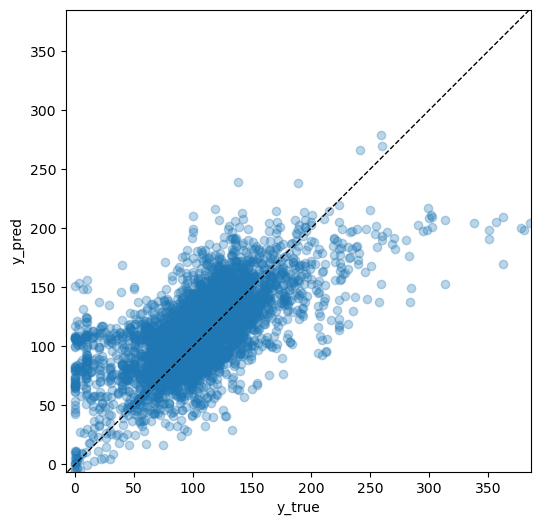

In [37]:
# ...existing code...
import matplotlib.pyplot as plt
import numpy as np

x = y_true.flatten()
y = y_pred.flatten()

plt.figure(figsize=(6,6))
plt.scatter(x, y, alpha=0.3)

mn = float(np.nanmin([x.min(), y.min()]))
mx = float(np.nanmax([x.max(), y.max()]))

plt.plot([mn, mx], [mn, mx], linestyle='--', color='k', linewidth=1)  # dashed x=y line
plt.xlabel('y_true')
plt.ylabel('y_pred')
plt.axis('equal')
plt.xlim(mn, mx)
plt.ylim(mn, mx)
plt.show()
# ...existing code...

In [39]:
y_test_raw

array([[[-8.190e+00],
        [-8.490e+00],
        [-1.000e-02],
        ...,
        [-3.900e+00],
        [-6.760e+00],
        [-5.100e+00]],

       [[-8.200e-01],
        [ 9.900e-01],
        [ 6.000e-02],
        ...,
        [-1.677e+01],
        [-1.730e+01],
        [-3.470e+00]],

       [[-1.369e+01],
        [-1.690e+00],
        [-7.770e+00],
        ...,
        [-1.819e+01],
        [-1.800e-01],
        [-1.360e+00]],

       ...,

       [[ 1.101e+01],
        [ 2.310e+00],
        [-1.454e+01],
        ...,
        [ 1.220e+00],
        [-1.710e+00],
        [-3.920e+00]],

       [[-3.840e+00],
        [-1.050e+00],
        [-4.730e+00],
        ...,
        [-1.206e+01],
        [-3.290e+00],
        [-1.190e+00]],

       [[ 3.100e-01],
        [-2.060e+00],
        [-1.610e+00],
        ...,
        [-1.180e+01],
        [-8.270e+00],
        [-2.840e+00]]])

In [47]:
# --- Imports (adjust the import path to your package layout) ---
from price_forecast.models.lstm_seq2seq_plus import LSTMSeq2SeqPlus  # the new model
from price_forecast.models.lstm_seq2seq import LSTMSeq2SeqModel      # old model (for evaluate reuse)

# X_train: (batch, input_steps, n_features)
# y_train: (batch, output_steps, output_dim)

# 1) Build the model by inferring shapes from data, with all hyperparams explicit
model_plus = LSTMSeq2SeqPlus.from_training_data(
    X_train=X_train,
    y_train=y_train,
    # --- Architecture ---
    enc_units=(128, 64),        # stacked encoder LSTMs; try (256,128) or (64,32)
    dec_units=128,              # decoder LSTM size; try 64/256
    bidirectional=True,         # use BiLSTM in encoder
    attention=True,             # AdditiveAttention over encoder sequence
    dropout=0.2,                # dropout between LSTM timesteps (Keras 'dropout')
    recurrent_dropout=0.0,      # use sparingly; slows training if >0
    layernorm=True,             # LayerNormalization after enc/dec
    residual_last24=True,       # concat projected last-24 inputs into the head
    # --- Training config (compile) ---
    optimizer="adam",
    loss="mse",
    metrics=("mae",),           # can add more, e.g. ("mae","mape")
    # --- Reproducibility ---
    seed=42,
)

# 2) Train (explicit tail validation split to keep temporal order)
split = int(0.9 * X_train.shape[0])
history_plus = model_plus.fit(
    X_train=X_train[:split],
    y_train=y_train[:split],
    X_val=X_train[split:],
    y_val=y_train[split:],
    epochs=80,                 # a bit higher by default for the larger model
    batch_size=64,
    patience=10,
    min_delta=1e-4,
    reduce_lr_patience=5,
    checkpoint_path="best_lstm_plus.keras",  # saves the full model
    verbose=1,
    shuffle=False,             # keep temporal ordering
)

# 3) Predict (scaled), inverse-transform, evaluate, and persist
y_pred_scaled_plus = model_plus.predict(X_test, batch_size=256, verbose=0)
y_pred_plus = builder.inverse_transform_target(y_pred_scaled_plus, bases=y_test_bases,diff_as_target=True)
y_true = builder.inverse_transform_target(y_test, bases=y_test_bases,diff_as_target=True)

print(LSTMSeq2SeqModel.evaluate(y_true, y_pred))
print("PLUS metrics:", LSTMSeq2SeqModel.evaluate(y_true, y_pred_plus))  # reuse the same evaluate helper

# 4) Save & (optionally) restore
model_plus.save("final_lstm_plus.keras")
restored_plus = LSTMSeq2SeqPlus.load("best_lstm_plus.keras")


Model: "lstm_seq2seq_plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 720, 29)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidir_enc_1         │ [(None, 720,      │    161,792 │ inputs[0][0]      │
│ (Bidirectional)     │ 256), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_ln_1            │ (None, 720, 256)  │        512 │ bidir_enc_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidir_enc_2         │ [(None, 720,      │    164,352 │ enc_ln_1[0][0]    │
│ (Bidirectional)     │ 128), (None, 64), │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_ln_2            │ (None, 720, 128)  │        256 │ bidir_enc_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_avg_pool        │ (None, 128)       │          0 │ enc_ln_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_2_h_concat      │ (None, 128)       │          0 │ bidir_enc_2[0][1… │
│ (Concatenate)       │                   │            │ bidir_enc_2[0][3] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_2_c_concat      │ (None, 128)       │          0 │ bidir_enc_2[0][2… │
│ (Concatenate)       │                   │            │ bidir_enc_2[0][4] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_output_steps │ (None, 24, 128)   │          0 │ enc_avg_pool[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init_h (Dense)      │ (None, 128)       │     16,512 │ enc_2_h_concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init_c (Dense)      │ (None, 128)       │     16,512 │ enc_2_c_concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_lstm (LSTM)     │ [(None, 24, 128), │    131,584 │ repeat_output_st… │
│                     │ (None, 128),      │            │ init_h[0][0],     │
│                     │ (None, 128)]      │            │ init_c[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_ln              │ (None, 24, 128)   │        256 │ dec_lstm[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 24, 128)   │        128 │ dec_ln[0][0],     │
│ (AdditiveAttention) │                   │            │ enc_ln_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last24_slice        │ (None, 24, 29)    │          0 │ inputs[0][0]      │
│ (Cropping1D)        │                   │            │                 

 Total params: 527,457 (2.01 MB)

 Trainable params: 527,457 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.6689 - mae: 1.0011
Epoch 1: val_loss improved from None to 0.58642, saving model to best_lstm_plus.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 78s 5s/step - loss: 2.0651 - mae: 1.0702 - val_loss: 0.5864 - val_mae: 0.5374 - learning_rate: 0.0010
Epoch 2/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.1244 - mae: 0.7841
Epoch 2: val_loss did not improve from 0.58642
13/13 ━━━━━━━━━━━━━━━━━━━━ 69s 5s/step - loss: 1.8014 - mae: 0.9733 - val_loss: 2.1515 - val_mae: 1.3128 - learning_rate: 0.0010
Epoch 3/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - loss: 1.1707 - mae: 0.8672
Epoch 3: val_loss improved from 0.58642 to 0.50963, saving model to best_lstm_plus.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 70s 5s/step - loss: 1.6043 - mae: 0.9461 - val_loss: 0.5096 - val_mae: 0.4728 - learning_rate: 0.0010
Epoch 4/80
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - loss: 0.5300 - mae: 0.4591
Epoch 4: val_loss improved from 0.50963 to 0.50728, saving model to best_lstm_p

Model: "lstm_seq2seq_plus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ inputs (InputLayer) │ (None, 720, 29)   │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidir_enc_1         │ [(None, 720,      │    161,792 │ inputs[0][0]      │
│ (Bidirectional)     │ 256), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128), (None,      │            │                   │
│                     │ 128)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_ln_1            │ (None, 720, 256)  │        512 │ bidir_enc_1[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidir_enc_2         │ [(None, 720,      │    164,352 │ enc_ln_1[0][0]    │
│ (Bidirectional)     │ 128), (None, 64), │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_ln_2            │ (None, 720, 128)  │        256 │ bidir_enc_2[0][0] │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_avg_pool        │ (None, 128)       │          0 │ enc_ln_2[0][0]    │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_2_h_concat      │ (None, 128)       │          0 │ bidir_enc_2[0][1… │
│ (Concatenate)       │                   │            │ bidir_enc_2[0][3] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ enc_2_c_concat      │ (None, 128)       │          0 │ bidir_enc_2[0][2… │
│ (Concatenate)       │                   │            │ bidir_enc_2[0][4] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ repeat_output_steps │ (None, 24, 128)   │          0 │ enc_avg_pool[0][… │
│ (RepeatVector)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init_h (Dense)      │ (None, 128)       │     16,512 │ enc_2_h_concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ init_c (Dense)      │ (None, 128)       │     16,512 │ enc_2_c_concat[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_lstm (LSTM)     │ [(None, 24, 128), │    131,584 │ repeat_output_st… │
│                     │ (None, 128),      │            │ init_h[0][0],     │
│                     │ (None, 128)]      │            │ init_c[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dec_ln              │ (None, 24, 128)   │        256 │ dec_lstm[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention  │ (None, 24, 128)   │        128 │ dec_ln[0][0],     │
│ (AdditiveAttention) │                   │            │ enc_ln_2[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ last24_slice        │ (None, 24, 29)    │          0 │ inputs[0][0]      │
│ (Cropping1D)        │                   │            │                 

 Total params: 527,457 (2.01 MB)

 Trainable params: 527,457 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

## Naive predictions (benchmark) [same as previous day]

In [36]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

test_start_date = y_test_df_raw['datetime'].min()
test_df = df[df['datetime_local'] >= test_start_date].copy()
naive_mae = mean_absolute_error(test_df['dam_price_eur_mwh'], test_df['previous_day_dam'])
naive_mse = mean_squared_error(test_df['dam_price_eur_mwh'], test_df['previous_day_dam'])
print("Naive (previous day) baseline:")
print("MSE:", naive_mse, "MAE:", naive_mae)

Naive (previous day) baseline:
MSE: 1096.3775449247814 MAE: 22.381166894875395


## Test with relative features

In [10]:
datetime_col = "datetime_local"
target_col   = "dam_price_eur_mwh"
main_series  = "previous_day_dam"

In [11]:
from sklearn.preprocessing import StandardScaler
from price_forecast.config import DatasetCfg
from price_forecast.config import SafeStandardScaler

cfg = DatasetCfg(
    datetime_col=datetime_col,
    target_col=target_col,
    main_series=main_series,        # used for feature ordering
    put_main_first=True,            # keep previous_day_dam as first feature
    n_lookback_days=30,              # encoder lookback (=> input_steps = 7*24)
    test_size=0.2,                  # tail split by whole days
    scale_features=True,
    feature_scaler=SafeStandardScaler(),
    scale_target=True,
    target_scaler=SafeStandardScaler())

In [14]:
from price_forecast.datasets.daily_sequence import DailySequenceDataset

builder = DailySequenceDataset(df, cfg)

# Example 1: Predict ABSOLUTE target; drop *_diff target from X
out = builder.build(keep_only_diff=False,
                     diff_as_target=False, return_dfs=True)   



c:\Users\HarrisDeralas\Downloads\panagiotis_files\price_forecast\src\price_forecast\datasets\daily_sequence.py:321: FutureWarning: Series.view is deprecated and will be removed in a future version. Use ``astype`` as an alternative to change the dtype.
  if not np.all(diffs.view("i8") == pd.Timedelta(hours=1).value):


In [15]:
out = builder.build(return_dfs=True)

X_train, X_test = out["X_train"], out["X_test"]        # (S, N*24, F)
y_train, y_test = out["y_train"], out["y_test"]        # (S, 24, 1)


# tidy inspection (raw vs scaled)
X_train_df_raw = out["X_train_df_raw"]
X_train_df_scaled = out["X_train_df"]
y_train_df_raw = out["y_train_df_raw"]
X_test_df_raw = out["X_test_df_raw"]
y_test_df_raw = out["y_test_df_raw"]



In [1]:
df.loc[df['datetime_local'] >= y_test_df_raw['datetime'].min()]

NameError: name 'df' is not defined

In [40]:
y_test_df_raw

datetime  dam_price_eur_mwh_diff
sample hour                                                  
0      0    2023-05-21 01:00:00+03:00                   -8.19
       1    2023-05-21 02:00:00+03:00                   -8.49
       2    2023-05-21 03:00:00+03:00                   -0.01
       3    2023-05-21 04:00:00+03:00                   -3.40
       4    2023-05-21 05:00:00+03:00                    3.40
...                               ...                     ...
224    19   2023-12-31 19:00:00+02:00                   -8.96
       20   2023-12-31 20:00:00+02:00                    5.21
       21   2023-12-31 21:00:00+02:00                  -11.80
       22   2023-12-31 22:00:00+02:00                   -8.27
       23   2023-12-31 23:00:00+02:00                   -2.84

[5400 rows x 2 columns]

In [23]:
from price_forecast.models.lstm_seq2seq import LSTMSeq2SeqModel

model = LSTMSeq2SeqModel.from_training_data(
    X_train, y_train,
    lstm_units=15 * 8,      # your earlier choice
    dropout=0.2,
    recurrent_dropout=0.0,
    optimizer="adam",
    loss="mse",
    metrics=("mae",),
    seed=42,
)

# Tail validation split is handled inside .fit() if you don't pass X_val/y_val
history = model.fit(
    X_train=X_train, y_train=y_train,
    epochs=60,
    batch_size=64,
    patience=10,
    reduce_lr_patience=5,
    checkpoint_path="best_lstm.keras",   # saves the full model
    verbose=1,
    shuffle=False,                       # keep temporal ordering
)



c:\Users\HarrisDeralas\anaconda3\envs\price-forecast\lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "lstm_seq2seq_day_ahead"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_lstm (LSTM)             │ (None, 120)            │        72,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ encoder_dropout (Dropout)       │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ repeat_output_steps             │ (None, 24, 120)        │             0 │
│ (RepeatVector)                  │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_lstm (LSTM)             │ (None, 24, 120)        │       115,680 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder_dropout (Dropout)       │ (None, 24, 120)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hourly_output (TimeDistributed) │ (None, 24, 1)          │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 187,801 (733.60 KB)

 Trainable params: 187,801 (733.60 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - loss: 1.2555 - mae: 1.0063
Epoch 1: val_loss improved from None to 0.20042, saving model to best_lstm.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 19s 1s/step - loss: 1.5114 - mae: 1.0240 - val_loss: 0.2004 - val_mae: 0.3635 - learning_rate: 0.0010
Epoch 2/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 900ms/step - loss: 0.4690 - mae: 0.5968
Epoch 2: val_loss improved from 0.20042 to 0.18300, saving model to best_lstm.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 12s 946ms/step - loss: 0.4502 - mae: 0.5382 - val_loss: 0.1830 - val_mae: 0.3589 - learning_rate: 0.0010
Epoch 3/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 986ms/step - loss: 0.2513 - mae: 0.3950
Epoch 3: val_loss improved from 0.18300 to 0.12517, saving model to best_lstm.keras
13/13 ━━━━━━━━━━━━━━━━━━━━ 13s 1s/step - loss: 0.3408 - mae: 0.4374 - val_loss: 0.1252 - val_mae: 0.2787 - learning_rate: 0.0010
Epoch 4/60
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 996ms/step - loss: 0.2639 - mae: 0.3934
Epoch 4: val_loss did not improve from 0

In [ ]:
if out["meta"]["target_mode"] == "diff":
    bases = out["y_test_bases"]
    y_pred_abs = builder.inverse_transform_target(y_pred_scaled, diff_as_target=True,  bases=bases)
    y_true_abs = builder.inverse_transform_target(y_test,         diff_as_target=True,  bases=bases)
else:
    y_pred_abs = builder.inverse_transform_target(y_pred_scaled, diff_as_target=False)
    y_true_abs = builder.inverse_transform_target(y_test, diff_as_target=False)

metrics = LSTMSeq2SeqModel.evaluate(y_true_abs, y_pred_abs)
print("Test metrics (abs units):", metrics)

In [11]:
y_pred_test_scaled = model.predict(X_test, batch_size=256, verbose=0)

In [12]:
# The dataset helper handles both scaling-only and relative+scaling modes.
if y_test_bases is not None:
    # Relative mode: provide per-sample bases
    y_pred_test_abs = builder.inverse_transform_target(y_pred_test_scaled, bases=y_test_bases)
    y_true_test_abs = builder.inverse_transform_target(y_test,             bases=y_test_bases)
else:
    # Absolute mode (no relative deltas): inverse scaling only (or no-op if disabled)
    y_pred_test_abs = builder.inverse_transform_target(y_pred_test_scaled)
    y_true_test_abs = builder.inverse_transform_target(y_test)

# -------------------------
# 7) Simple evaluation (MAE/MSE)
# -------------------------
metrics = LSTMSeq2SeqModel.evaluate(y_true_test_abs, y_pred_test_abs)
print("Test metrics (abs units):", metrics)

Test metrics (abs units): {'mse': 1.617213708006274e+23, 'mae': 41342048544.763695}
